# Demo 2: Tokenization and Cost Analysis

In this demo, you'll learn how LLMs break text into tokens and why it matters for your wallet! We'll explore:

1. **What are tokens?** - How LLMs see text
2. **Token counting** - Using tiktoken to count tokens
3. **Cost calculations** - Understanding API pricing
4. **Conversation growth** - How chat history affects costs
5. **Optimization strategies** - Reducing costs without sacrificing quality

## Learning Objectives

By the end of this demo, you'll understand:
- How text gets converted into tokens
- Why token count matters more than word count
- How to calculate API costs for your application
- Strategies to optimize token usage and reduce costs

## Setup

First, let's install and import the required libraries.

In [1]:
# Install tiktoken if needed
# !pip install tiktoken matplotlib pandas
from dotenv import load_dotenv
import os
import tiktoken
import matplotlib.pyplot as plt
import pandas as pd
from openai import OpenAI

load_dotenv()

# Initialize OpenAI client
api_key = os.getenv("OPENAI_API_KEY")
base_url = os.getenv("OPENAI_API_URL")
client = OpenAI(
    api_key=api_key,
    base_url=base_url
)

print("✅ Libraries imported successfully!")

✅ Libraries imported successfully!


## Part 1: What Are Tokens?

Tokens are **chunks of text** that the LLM processes. They're not quite words!

- Common words = 1 token ("hello", "world")
- Uncommon words = multiple tokens ("tokenization" might be 2-3)
- Numbers and symbols = often 1 token each
- Spaces and punctuation = separate tokens

Let's see how different texts tokenize!

In [2]:
# Get the tokenizer for GPT-3.5/GPT-4
encoding = tiktoken.encoding_for_model("gpt-3.5-turbo")

def show_tokens(text):
    """Show how text is split into tokens."""
    tokens = encoding.encode(text)
    token_strings = [encoding.decode([token]) for token in tokens]
    
    print(f"Text: '{text}'")
    print(f"Token count: {len(tokens)}")
    print(f"Tokens: {token_strings}\n")
    
    return len(tokens)

# Examples
print("📝 Simple Examples:\n")
show_tokens("Hello world")
show_tokens("Hello, world!")
show_tokens("Tokenization")
show_tokens("AI is amazing")
show_tokens("GPT-3.5-turbo")

📝 Simple Examples:

Text: 'Hello world'
Token count: 2
Tokens: ['Hello', ' world']

Text: 'Hello, world!'
Token count: 4
Tokens: ['Hello', ',', ' world', '!']

Text: 'Tokenization'
Token count: 2
Tokens: ['Token', 'ization']

Text: 'AI is amazing'
Token count: 3
Tokens: ['AI', ' is', ' amazing']

Text: 'GPT-3.5-turbo'
Token count: 9
Tokens: ['G', 'PT', '-', '3', '.', '5', '-t', 'ur', 'bo']



9

### 💡 Key Insight

Notice how:
- Punctuation adds tokens!
- Technical terms may split into multiple tokens
- Numbers and special characters count as tokens

**Rule of thumb**: 1 token ≈ 4 characters for English text

## Part 2: Token Count Comparisons

Let's compare how different types of messages tokenize.

In [3]:
# Sample customer service messages
messages = {
    "Short query": "Where is my order?",
    "Medium query": "I ordered a product 5 days ago but haven't received a tracking number. Can you help?",
    "Long query": "I placed an order on January 15th for three items: a blue backpack, a water bottle, and hiking boots. I received an email confirmation but no shipping notification. My order number is #12345. Can you check the status and let me know when it will arrive? I need it by next week for a trip.",
    "Technical": "ERROR: NullPointerException in payment.processTransaction() at line 247",
    "With emojis": "Thanks so much! 😊 You've been really helpful! 🎉 Have a great day! ⭐"
}

# Count tokens for each
results = []
for msg_type, text in messages.items():
    token_count = len(encoding.encode(text))
    word_count = len(text.split())
    char_count = len(text)
    
    results.append({
        "Message Type": msg_type,
        "Characters": char_count,
        "Words": word_count,
        "Tokens": token_count,
        "Tokens/Word": f"{token_count/word_count:.2f}" if word_count > 0 else "N/A"
    })

# Display as a table
df = pd.DataFrame(results)
print("📊 Token Count Comparison:\n")
print(df.to_string(index=False))

# Show actual messages
print("\n" + "="*80 + "\n")
print("📨 Sample Messages:\n")
for msg_type, text in messages.items():
    print(f"{msg_type}: \"{text}\"")
    print()

📊 Token Count Comparison:

Message Type  Characters  Words  Tokens Tokens/Word
 Short query          18      4       5        1.25
Medium query          84     16      20        1.25
  Long query         288     55      67        1.22
   Technical          71      7      12        1.71
 With emojis          67     14      22        1.57


📨 Sample Messages:

Short query: "Where is my order?"

Medium query: "I ordered a product 5 days ago but haven't received a tracking number. Can you help?"

Long query: "I placed an order on January 15th for three items: a blue backpack, a water bottle, and hiking boots. I received an email confirmation but no shipping notification. My order number is #12345. Can you check the status and let me know when it will arrive? I need it by next week for a trip."

Technical: "ERROR: NullPointerException in payment.processTransaction() at line 247"

With emojis: "Thanks so much! 😊 You've been really helpful! 🎉 Have a great day! ⭐"



## Part 3: API Cost Calculations

Now let's calculate the actual costs! OpenAI pricing (as of 2024):

| Model | Input (per 1K tokens) | Output (per 1K tokens) |
|-------|----------------------|------------------------|
| GPT-3.5-turbo | $0.0005 | $0.0015 |
| GPT-4 | $0.03 | $0.06 |
| GPT-4-turbo | $0.01 | $0.03 |

In [4]:
# Pricing (per 1000 tokens)
PRICING = {
    "gpt-3.5-turbo": {"input": 0.0005, "output": 0.0015},
    "gpt-4": {"input": 0.03, "output": 0.06},
    "gpt-4-turbo": {"input": 0.01, "output": 0.03}
}

def calculate_cost(input_tokens, output_tokens, model="gpt-3.5-turbo"):
    """Calculate the cost of an API call."""
    input_cost = (input_tokens / 1000) * PRICING[model]["input"]
    output_cost = (output_tokens / 1000) * PRICING[model]["output"]
    total_cost = input_cost + output_cost
    
    return {
        "input_cost": input_cost,
        "output_cost": output_cost,
        "total_cost": total_cost
    }

# Example: Customer service interaction
system_prompt = """You are a helpful customer service assistant for ShopEasy. 
Be professional, empathetic, and provide clear information."""

user_message = "I ordered a product 5 days ago but haven't received a tracking number. Can you help?"

# Typical response length
assistant_response = """I apologize for the delay in receiving your tracking information. 
I'd be happy to help you track your order. Could you please provide me with your order number? 
It should be in your confirmation email and starts with #. Once I have that, 
I can look up the current status and provide you with tracking details."""

# Count tokens
system_tokens = len(encoding.encode(system_prompt))
user_tokens = len(encoding.encode(user_message))
response_tokens = len(encoding.encode(assistant_response))

input_tokens = system_tokens + user_tokens
output_tokens = response_tokens

print("🎯 Single Interaction Breakdown:\n")
print(f"System prompt: {system_tokens} tokens")
print(f"User message: {user_tokens} tokens")
print(f"Assistant response: {response_tokens} tokens")
print(f"\nTotal input: {input_tokens} tokens")
print(f"Total output: {output_tokens} tokens\n")

# Calculate costs for different models
print("💰 Cost Comparison by Model:\n")
for model in PRICING.keys():
    costs = calculate_cost(input_tokens, output_tokens, model)
    print(f"{model}:")
    print(f"  Input cost:  ${costs['input_cost']:.6f}")
    print(f"  Output cost: ${costs['output_cost']:.6f}")
    print(f"  Total cost:  ${costs['total_cost']:.6f}")
    print()

🎯 Single Interaction Breakdown:

System prompt: 23 tokens
User message: 20 tokens
Assistant response: 66 tokens

Total input: 43 tokens
Total output: 66 tokens

💰 Cost Comparison by Model:

gpt-3.5-turbo:
  Input cost:  $0.000021
  Output cost: $0.000099
  Total cost:  $0.000121

gpt-4:
  Input cost:  $0.001290
  Output cost: $0.003960
  Total cost:  $0.005250

gpt-4-turbo:
  Input cost:  $0.000430
  Output cost: $0.001980
  Total cost:  $0.002410



### 💡 Key Insight

Notice that:
- **Output tokens cost MORE** than input tokens (often 2-3x)
- **GPT-4 is 60x more expensive** than GPT-3.5-turbo
- A single interaction costs fractions of a cent
- But thousands of interactions add up quickly!

## Part 4: Conversation History Token Growth

The real cost killer is **conversation history**. Each message adds to the context sent with every request!

📈 Token Growth Over Conversation:

Turn 1 (system): 11 tokens ($0.000081 per API call)
Turn 2 (user): 16 tokens ($0.000083 per API call)
Turn 3 (assistant): 30 tokens ($0.000090 per API call)
Turn 4 (user): 34 tokens ($0.000092 per API call)
Turn 5 (assistant): 68 tokens ($0.000109 per API call)
Turn 6 (user): 75 tokens ($0.000112 per API call)
Turn 7 (assistant): 120 tokens ($0.000135 per API call)
Turn 8 (user): 127 tokens ($0.000139 per API call)


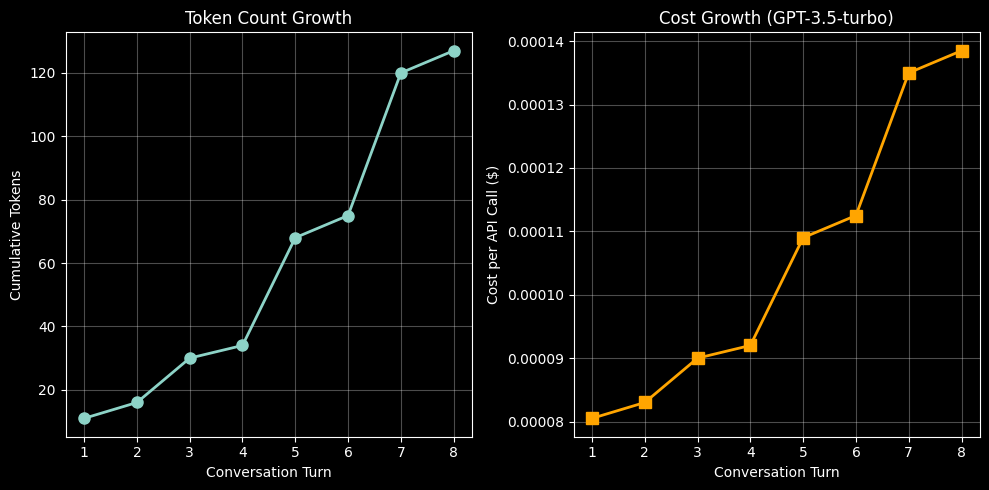


⚠️ Final conversation: 127 tokens
That's 11.5x the initial size!


In [5]:
# Simulate a conversation
conversation = [
    {"role": "system", "content": "You are a helpful customer service assistant for ShopEasy."},
    {"role": "user", "content": "Where is my order?"},
    {"role": "assistant", "content": "I'd be happy to help! Could you provide your order number?"},
    {"role": "user", "content": "Order #12345"},
    {"role": "assistant", "content": "Thank you! Let me check that for you. Your order shipped yesterday and should arrive in 2-3 business days. Your tracking number is TRK789456."},
    {"role": "user", "content": "Can I change the delivery address?"},
    {"role": "assistant", "content": "I understand you'd like to change the delivery address. Unfortunately, since the order has already shipped, we can't modify the address directly. However, you can contact the carrier using your tracking number to request a delivery redirect."},
    {"role": "user", "content": "How do I contact the carrier?"},
]

# Calculate cumulative tokens at each turn
cumulative_tokens = []
turn_numbers = []
turn_costs = []

for i in range(1, len(conversation) + 1):
    # Count tokens in conversation up to this point
    messages_so_far = conversation[:i]
    total_tokens = sum(len(encoding.encode(msg["content"])) for msg in messages_so_far)
    
    cumulative_tokens.append(total_tokens)
    turn_numbers.append(i)
    
    # Estimate cost (assuming average 50 token response)
    cost = calculate_cost(total_tokens, 50, "gpt-3.5-turbo")["total_cost"]
    turn_costs.append(cost)

# Show the data
print("📈 Token Growth Over Conversation:\n")
for i, (turn, tokens, cost) in enumerate(zip(turn_numbers, cumulative_tokens, turn_costs)):
    role = conversation[i]["role"]
    print(f"Turn {turn} ({role}): {tokens} tokens (${cost:.6f} per API call)")

# Visualize
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(turn_numbers, cumulative_tokens, marker='o', linewidth=2, markersize=8)
plt.xlabel('Conversation Turn')
plt.ylabel('Cumulative Tokens')
plt.title('Token Count Growth')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(turn_numbers, turn_costs, marker='s', color='orange', linewidth=2, markersize=8)
plt.xlabel('Conversation Turn')
plt.ylabel('Cost per API Call ($)')
plt.title('Cost Growth (GPT-3.5-turbo)')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n⚠️ Final conversation: {cumulative_tokens[-1]} tokens")
print(f"That's {cumulative_tokens[-1] / cumulative_tokens[0]:.1f}x the initial size!")

### 🚨 The Problem

As conversations grow:
- Each API call includes ALL previous messages
- Token count grows linearly (or worse)
- Costs increase with each turn
- You hit context limits (4K, 8K, 16K tokens depending on model)

## Part 5: Message Chunking Demonstration

For long texts, you might need to chunk them. Let's see how!

In [6]:
def chunk_text_by_tokens(text, max_tokens=100, overlap=20):
    """Split text into chunks with a maximum token count."""
    tokens = encoding.encode(text)
    chunks = []
    
    start = 0
    while start < len(tokens):
        # Get chunk
        end = start + max_tokens
        chunk_tokens = tokens[start:end]
        chunk_text = encoding.decode(chunk_tokens)
        
        chunks.append({
            "text": chunk_text,
            "tokens": len(chunk_tokens),
            "start": start,
            "end": end
        })
        
        # Move start forward, accounting for overlap
        start = end - overlap
    
    return chunks

# Long customer message
long_message = """I'm writing to express my frustration with my recent order experience. 
I ordered three items on January 15th: a blue hiking backpack (SKU: BP-123), a stainless 
steel water bottle (SKU: WB-456), and a pair of hiking boots size 10 (SKU: HB-789). 
My order number is #12345. I received a confirmation email immediately, which was great, 
but then nothing for five days. No shipping notification, no tracking number, nothing. 
I tried to check the order status on your website, but the tracking page just shows 
'processing' with no additional information. I called customer service twice, and both 
times I was on hold for over 30 minutes before giving up. I really need these items by 
next Friday because I'm leaving for a week-long hiking trip, and I specifically chose 
expedited shipping at checkout, which cost me an extra $25. Can someone please help me 
figure out where my order is and when it will actually arrive? This is very time-sensitive."""

print(f"Original text: {len(encoding.encode(long_message))} tokens\n")
print("="*80 + "\n")

# Chunk it
chunks = chunk_text_by_tokens(long_message, max_tokens=100, overlap=20)

print(f"📦 Split into {len(chunks)} chunks:\n")
for i, chunk in enumerate(chunks, 1):
    print(f"Chunk {i} ({chunk['tokens']} tokens):")
    print(f"  \"{chunk['text'][:100]}...\"")
    print()

Original text: 216 tokens


📦 Split into 3 chunks:

Chunk 1 (100 tokens):
  "I'm writing to express my frustration with my recent order experience. 
I ordered three items on Jan..."

Chunk 2 (100 tokens):
  " which was great, 
but then nothing for five days. No shipping notification, no tracking number, not..."

Chunk 3 (56 tokens):
  " Friday because I'm leaving for a week-long hiking trip, and I specifically chose 
expedited shippin..."



## Part 6: Cost Optimization Strategies

Let's explore techniques to reduce costs without sacrificing quality.

💡 Cost Optimization Strategies:

📊 Baseline (keep all history):
   Include entire conversation in every request
   Total cost (8 turns): $0.002010
   Quality: High
   Context retention: 100%

📊 Keep last 3 messages:
   Only include system + last 3 messages
   Total cost (8 turns): $0.001285
   Quality: Medium-High
   Context retention: ~40%

📊 Summarize old messages:
   Summarize messages older than 4 turns
   Total cost (8 turns): $0.001660
   Quality: High
   Context retention: ~70%

📊 No history (stateless):
   Only send current message
   Total cost (8 turns): $0.000800
   Quality: Low
   Context retention: 0%



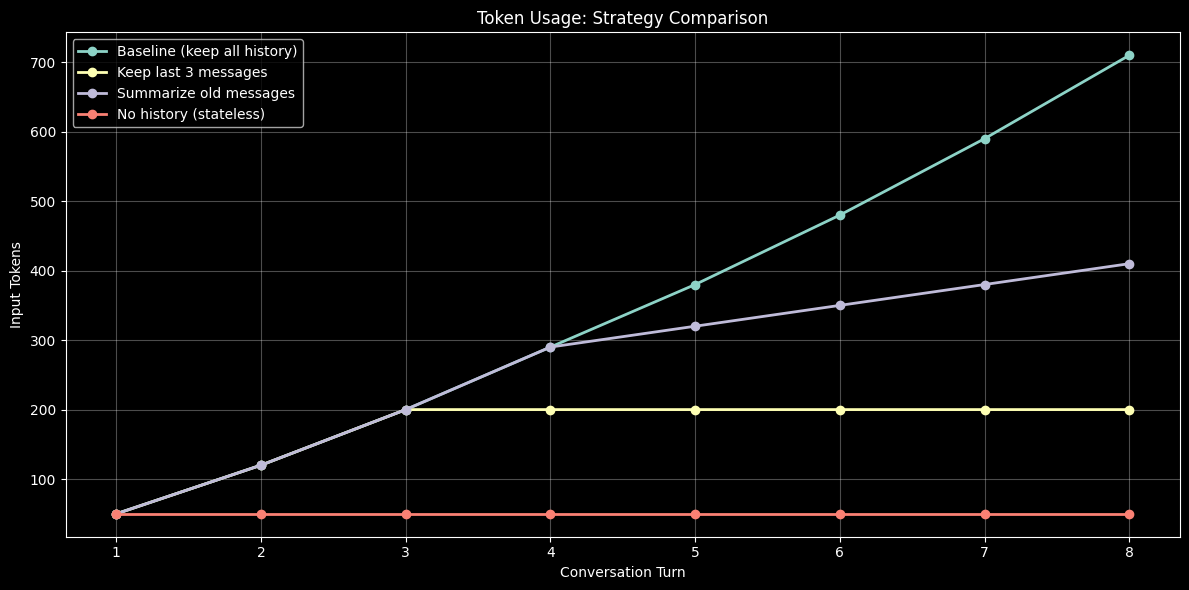


🎯 Recommendation: Use 'Summarize old messages' for best balance of cost and quality!


In [7]:
# Strategy comparison
strategies = {
    "Baseline (keep all history)": {
        "description": "Include entire conversation in every request",
        "tokens_per_turn": [50, 120, 200, 290, 380, 480, 590, 710],
        "quality": "High",
        "context_retention": "100%"
    },
    "Keep last 3 messages": {
        "description": "Only include system + last 3 messages",
        "tokens_per_turn": [50, 120, 200, 200, 200, 200, 200, 200],
        "quality": "Medium-High",
        "context_retention": "~40%"
    },
    "Summarize old messages": {
        "description": "Summarize messages older than 4 turns",
        "tokens_per_turn": [50, 120, 200, 290, 320, 350, 380, 410],
        "quality": "High",
        "context_retention": "~70%"
    },
    "No history (stateless)": {
        "description": "Only send current message",
        "tokens_per_turn": [50, 50, 50, 50, 50, 50, 50, 50],
        "quality": "Low",
        "context_retention": "0%"
    }
}

# Calculate costs for each strategy
print("💡 Cost Optimization Strategies:\n")

plt.figure(figsize=(12, 6))

for strategy_name, data in strategies.items():
    tokens = data["tokens_per_turn"]
    # Calculate cumulative cost (sum of all API calls)
    cumulative_cost = sum(
        calculate_cost(t, 50, "gpt-3.5-turbo")["total_cost"] 
        for t in tokens
    )
    
    print(f"📊 {strategy_name}:")
    print(f"   {data['description']}")
    print(f"   Total cost (8 turns): ${cumulative_cost:.6f}")
    print(f"   Quality: {data['quality']}")
    print(f"   Context retention: {data['context_retention']}")
    print()
    
    # Plot
    plt.plot(range(1, len(tokens) + 1), tokens, marker='o', label=strategy_name, linewidth=2)

plt.xlabel('Conversation Turn')
plt.ylabel('Input Tokens')
plt.title('Token Usage: Strategy Comparison')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\n🎯 Recommendation: Use 'Summarize old messages' for best balance of cost and quality!")

## Part 7: Real-World Cost Projection

Let's calculate costs for a realistic customer service application.

In [8]:
# Assumptions for a customer service chatbot
assumptions = {
    "daily_users": 1000,
    "avg_messages_per_user": 5,
    "avg_input_tokens_per_message": 200,  # includes history
    "avg_output_tokens_per_message": 100,
    "model": "gpt-3.5-turbo"
}

# Calculate costs
messages_per_day = assumptions["daily_users"] * assumptions["avg_messages_per_user"]
cost_per_message = calculate_cost(
    assumptions["avg_input_tokens_per_message"],
    assumptions["avg_output_tokens_per_message"],
    assumptions["model"]
)["total_cost"]

daily_cost = messages_per_day * cost_per_message
monthly_cost = daily_cost * 30
yearly_cost = daily_cost * 365

print("💰 Cost Projection for Customer Service Bot:\n")
print("Assumptions:")
for key, value in assumptions.items():
    print(f"  {key.replace('_', ' ').title()}: {value}")

print(f"\nCalculated Metrics:")
print(f"  Messages per day: {messages_per_day:,}")
print(f"  Cost per message: ${cost_per_message:.6f}")

print(f"\n📊 Projected Costs:")
print(f"  Daily:   ${daily_cost:.2f}")
print(f"  Monthly: ${monthly_cost:.2f}")
print(f"  Yearly:  ${yearly_cost:,.2f}")

# Compare with GPT-4
gpt4_cost_per_message = calculate_cost(
    assumptions["avg_input_tokens_per_message"],
    assumptions["avg_output_tokens_per_message"],
    "gpt-4"
)["total_cost"]
gpt4_yearly = messages_per_day * gpt4_cost_per_message * 365

print(f"\n🔄 If using GPT-4 instead:")
print(f"  Yearly cost: ${gpt4_yearly:,.2f}")
print(f"  Difference: ${gpt4_yearly - yearly_cost:,.2f} more per year")
print(f"  That's {gpt4_yearly / yearly_cost:.1f}x more expensive!")

💰 Cost Projection for Customer Service Bot:

Assumptions:
  Daily Users: 1000
  Avg Messages Per User: 5
  Avg Input Tokens Per Message: 200
  Avg Output Tokens Per Message: 100
  Model: gpt-3.5-turbo

Calculated Metrics:
  Messages per day: 5,000
  Cost per message: $0.000250

📊 Projected Costs:
  Daily:   $1.25
  Monthly: $37.50
  Yearly:  $456.25

🔄 If using GPT-4 instead:
  Yearly cost: $21,900.00
  Difference: $21,443.75 more per year
  That's 48.0x more expensive!


## 🎯 Key Takeaways

1. **Tokens ≠ Words** - Tokenization is model-specific and affects costs directly

2. **Output costs more** - Generated tokens are 2-3x more expensive than input

3. **Conversation history grows** - Each turn adds tokens, costs increase linearly

4. **Model choice matters** - GPT-4 is 60x more expensive than GPT-3.5-turbo

5. **Optimize strategically** - Summarize old messages or limit history to save costs

6. **Count before you commit** - Use tiktoken to estimate costs before deployment

## 💡 Cost Optimization Tips

1. **Truncate history**: Keep only the last N messages
2. **Summarize context**: Compress old messages into summaries
3. **Use cheaper models**: GPT-3.5-turbo for simple tasks, GPT-4 for complex ones
4. **Limit output**: Set max_tokens to avoid unnecessarily long responses
5. **Cache results**: Don't regenerate answers to common questions
6. **Smart routing**: Use embeddings/classification to route to appropriate model

## 🚀 Try It Yourself!

Experiments to run:
1. Calculate costs for your specific use case
2. Compare different message truncation strategies
3. Measure token counts for your actual prompts
4. Test chunking strategies for long documents

Next up: **Demo 3: Embeddings and Semantic Search** - Learn how to build smarter search with vector embeddings!